# Step 3: Build and train a DNN model to predict the hourly crop growth pattern from daily environmental conditions

*   Data import and visualization
*   Build a DNN model to capture the crop growth pattern per hour of a day from the evironmental daily input, based on the Greenlight dataset

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import tensorflow as tf
import seaborn as sns
import os
from google.colab import drive

print(os.getcwd())
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Analyze data <a class="anchor" id="2-bullet"></a>
- load data file
- pre-process data
- visualize data

In [ ]:
# load data file
df = pd.read_csv('/content/drive/MyDrive/INF_RP_CropModel/data_3to24.csv')
# pre-process data
df = df.rename(columns={"Unnamed: 0": "Day", 'co2Air':'CO2(ppm)','tAir':'Temperature(C)','vpAir':'Humidity(percent)'})
df["Day"] = df["Day"] + 1
df = df.set_index("Day")
df = df[:180]  # in this data, a meaningful group of crop data is 180 days

In [ ]:
print(df.columns)
print(df.info())
print(df)

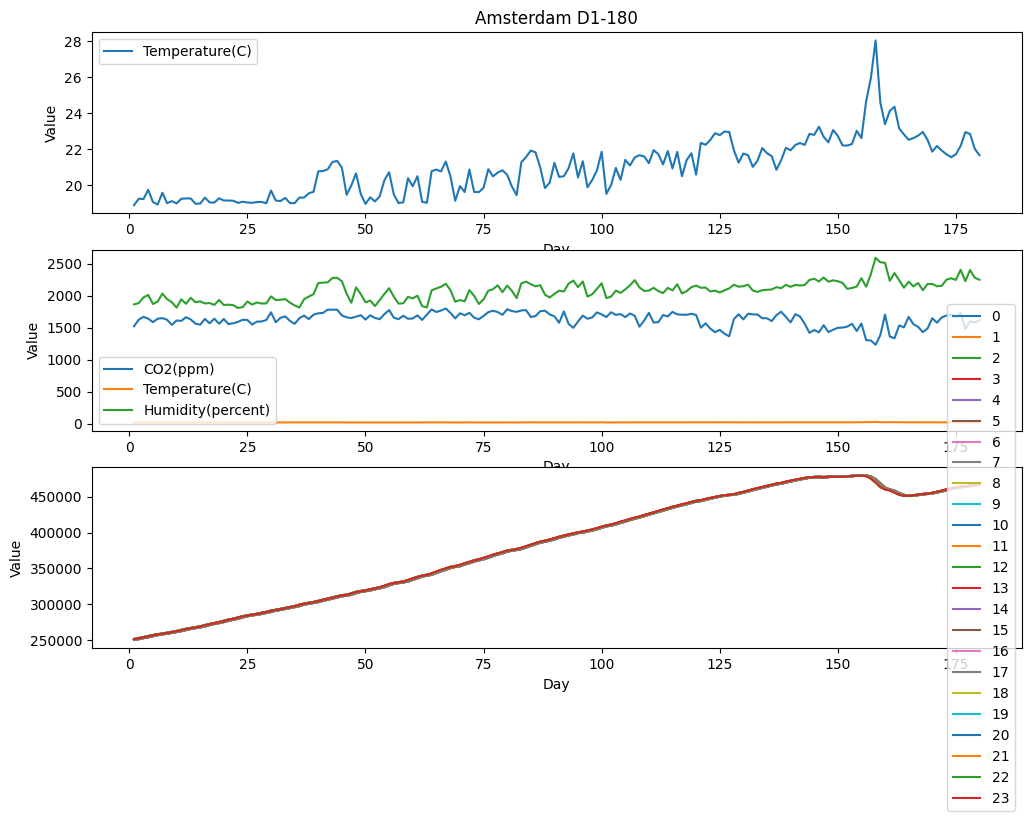

In [ ]:
# visualize data
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
for label in df.columns[1:2]:
    plt.plot(df[label], label=label)
plt.title('Amsterdam D1-180')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend(loc='best')

plt.subplot(3,1,2)
for label in df.columns[:3]:
    plt.plot(df[label], label=label)
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend(loc='best')

plt.subplot(3,1,3)
for label in df.columns[3:]:
    plt.plot(df[label], label=label)
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend(loc='right')

plt.show()

# 3. Manipulate data <a class="anchor" id="3-bullet"></a>
- enlarge the small dataset by adding noise
- normalize data
- create train and test data sets

In [ ]:
# enlarge the small dataset for better training performance by adding Gaussian noise
df_aug = df.copy()
for i in range(5000):
    noise = np.random.normal(loc=0, scale=1, size=df.shape)
    df_noise = df + noise
    df_aug = pd.concat([df_aug, df_noise])

In [ ]:
df_aug.to_csv('/content/drive/MyDrive/INF_RP_CropModel/data_3to24_augmented.csv')

In [ ]:
print(df_aug)

        CO2(ppm)  Temperature(C)  Humidity(percent)              0  \
Day                                                                  
1    1522.984623       18.877241        1863.419544  250000.000000   
2    1625.327310       19.235258        1884.159810  250873.004342   
3    1669.934916       19.216003        1972.829009  252322.624775   
4    1641.666875       19.732160        2011.918633  253559.696330   
5    1586.262388       19.047424        1870.226964  255094.938316   
..           ...             ...                ...            ...   
176  1733.778919       21.468139        2405.728346  463080.686908   
177  1480.841417       22.185981        2225.865373  464131.609582   
178  1595.572905       23.490775        2399.995235  464576.623276   
179  1581.654424       22.034671        2279.493349  465386.800331   
180  1613.935277       21.486601        2249.662961  466892.231981   

                 1              2              3              4  \
Day                   

In [ ]:
# min-max normalize by columns
df_norm = df_aug.copy()
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
for column in df_norm.columns.tolist():
    df_norm[column] = scaler.fit_transform(df_aug[column].values.reshape(-1,1))  # using array.reshape(-1, 1) for single feature

# set x and y
x = df_norm[['CO2(ppm)', 'Temperature(C)', 'Humidity(percent)']].values
y = df_norm.drop(columns=['CO2(ppm)', 'Temperature(C)', 'Humidity(percent)']).values

# split Train and Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)  # no shuffle: better capture cycling pattern in the data

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (720144, 3)
y_train.shape =  (720144, 24)
x_test.shape =  (180036, 3)
y_test.shape =  (180036, 24)


# 4. DNN model and Prediction <a class="anchor" id="5-bullet"></a>

In [ ]:
# Create model
model = tf.keras.models.Sequential()
# The input and first dense layer. set input shape (n input features)
model.add(tf.keras.layers.Dense(27, activation='relu', input_shape=(3,)))
# The hidden layers
model.add(tf.keras.layers.Dense(50,activation='relu'))
model.add(tf.keras.layers.Dense(40,activation='relu'))
model.add(tf.keras.layers.Dense(35,activation='relu'))
model.add(tf.keras.layers.Dense(30,activation='relu'))
# The output layer. # units in output layer = # output parameters
model.add(tf.keras.layers.Dense(24))
# Compile model
model.compile(optimizer='Adam',loss='mean_absolute_error')
# Fit model on The Train and Validation Dataset
model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          batch_size=180,epochs=120)

Epoch 1/120
4001/4001 [==============================] - 14s 3ms/step - loss: 0.1133 - val_loss: 0.0950
Epoch 2/120
4001/4001 [==============================] - 13s 3ms/step - loss: 0.0873 - val_loss: 0.0810
Epoch 3/120
4001/4001 [==============================] - 12s 3ms/step - loss: 0.0741 - val_loss: 0.0685
Epoch 4/120
4001/4001 [==============================] - 12s 3ms/step - loss: 0.0657 - val_loss: 0.0623
Epoch 5/120
4001/4001 [==============================] - 13s 3ms/step - loss: 0.0604 - val_loss: 0.0581
Epoch 6/120
4001/4001 [==============================] - 13s 3ms/step - loss: 0.0561 - val_loss: 0.0542
Epoch 7/120
4001/4001 [==============================] - 13s 3ms/step - loss: 0.0526 - val_loss: 0.0604
Epoch 8/120
4001/4001 [==============================] - 14s 3ms/step - loss: 0.0499 - val_loss: 0.0495
Epoch 9/120
4001/4001 [==============================] - 13s 3ms/step - loss: 0.0476 - val_loss: 0.0463
Epoch 10/120
4001/4001 [==============================] - 12s 3m

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 27)                108       
                                                                 
 dense_1 (Dense)             (None, 50)                1400      
                                                                 
 dense_2 (Dense)             (None, 40)                2040      
                                                                 
 dense_3 (Dense)             (None, 35)                1435      
                                                                 
 dense_4 (Dense)             (None, 30)                1080      
                                                                 
 dense_5 (Dense)             (None, 24)                744       
                                                                 
Total params: 6807 (26.59 KB)
Trainable params: 6807 (26

<Axes: xlabel='epoch'>

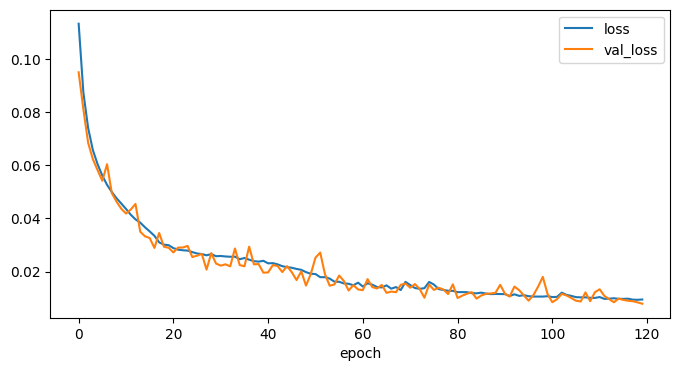

In [ ]:
history_df = pd.DataFrame(model.history.history)
history_df.plot(figsize=(8,4), xlabel='epoch')

In [ ]:
# Make test prediction
y_pred = model.predict(x_test)

5627/5627 [==============================] - 9s 2ms/step


In [ ]:
# calculate errors
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2_Score:', metrics.r2_score(y_test, y_pred))

MAE: 0.007902798205452368
MSE: 0.0006509623338667708
RMSE: 0.025513963507592677
R2_Score: 0.9938835000859984


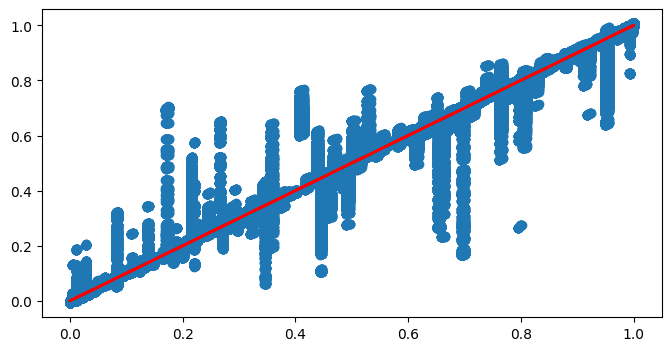

In [ ]:
# Visualize the test prediction compared with true value
plt.figure(figsize=(8,4))
plt.scatter(y_test,y_pred)
plt.plot(y_test,y_test,color='red')  # perfect prediction
plt.show()

In [ ]:
print(y_pred.shape)
print(y_pred)

(180036, 24)
[[0.9910487  0.99085724 0.99071103 ... 0.99198365 0.99178135 0.99268377]
 [0.991475   0.9913123  0.99110085 ... 0.9913185  0.99105215 0.9921    ]
 [0.9931556  0.9929325  0.9928535  ... 0.9934115  0.99316907 0.9939463 ]
 ...
 [0.93853253 0.9383866  0.9383652  ... 0.94112056 0.94106054 0.9417801 ]
 [0.942548   0.94243705 0.9423724  ... 0.94642895 0.94651735 0.94745636]
 [0.95012873 0.9500109  0.9499732  ... 0.95454645 0.9546939  0.95560026]]


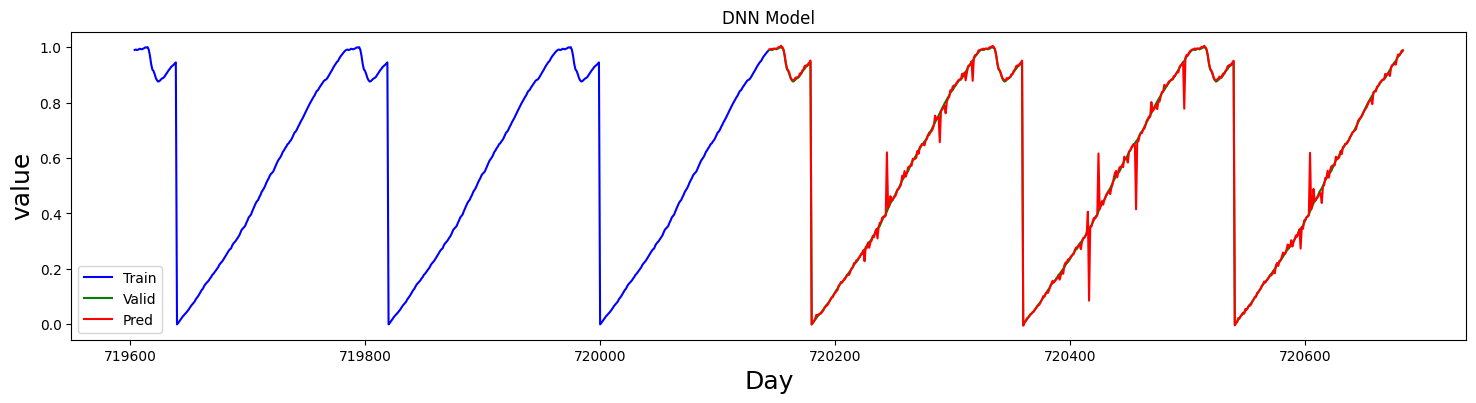

In [ ]:
# visualize prediction
train_size = int(len(df_norm)*0.8)
cycle = 180*3
train = df_norm[:train_size]
valid = df_norm[train_size:]

plt.figure(num=i, figsize=(18,4))
plt.plot(np.arange(train_size-cycle, train_size), train['12'][-cycle:], color='blue', label='Train')
plt.plot(np.arange(train_size, train_size+cycle), valid['12'][:cycle], color='green', label='Valid')
plt.plot(np.arange(train_size, train_size+cycle), y_pred[:cycle, 12], color='red', label='Pred')
plt.title('DNN Model')
plt.xlabel('Day', fontsize=18)
plt.ylabel('value', fontsize=18)
plt.legend(loc='best')
plt.show()

<ipython-input-16-fc968e518934>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals)


<Axes: ylabel='Density'>

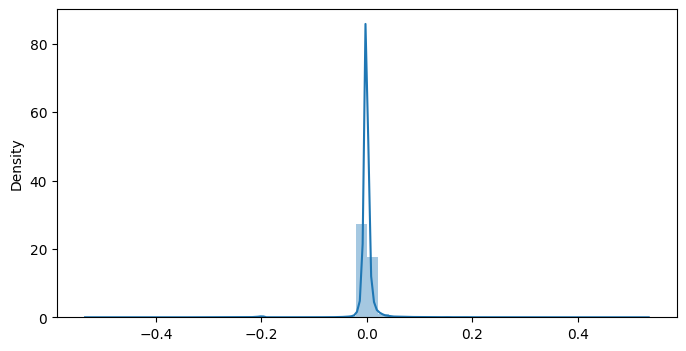

In [ ]:
# visualizing residuals
fig = plt.figure(figsize=(8,4))
residuals = (y_test - y_pred)
sns.distplot(residuals)

In [ ]:
# save the model
model.save('/content/drive/MyDrive/INF_RP_CropModel/DNN_model_yuyanyang.keras')  # change path according to your directory